In [1]:
import torch
import numpy as np
import sklearn
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import spacy
import string

In [3]:
import nltk
import tqdm
import pickle as pkl

In [4]:
import matplotlib.pyplot as plt

In [5]:
os.getcwd()
path = '/Users/williamgodel/Google Drive/Grad School/Year Three/NLP/HW1'

In [92]:
#loading train negative reviews
os.chdir('/Users/williamgodel/Google Drive/Grad School/Year Three/NLP/HW1/aclImdb/train/neg')

neg_rev = []
for x in os.listdir():
    neg_rev.append(open(x,'r').read())


#loading train positive reviews
os.chdir('/Users/williamgodel/Google Drive/Grad School/Year Three/NLP/HW1/aclImdb/train/pos')

pos_rev = []
for x in os.listdir():
    pos_rev.append(open(x,'r').read())

all_rev = neg_rev
all_rev.extend(pos_rev)
train_data = pd.DataFrame({"reviews":all_rev})
train_data['positive'] = 0
train_data.iloc[12500:,1] = 1

X_train, X_val, y_train, y_val = train_test_split(train_data['reviews'], train_data['positive'], test_size=0.2, random_state=42)

In [71]:
#loading test negative reviews
os.chdir('/Users/williamgodel/Google Drive/Grad School/Year Three/NLP/HW1/aclImdb/test/neg')

neg_rev = []
for x in os.listdir():
    neg_rev.append(open(x,'r').read())


#loading test positive reviews
os.chdir('/Users/williamgodel/Google Drive/Grad School/Year Three/NLP/HW1/aclImdb/test/pos')

pos_rev = []
for x in os.listdir():
    pos_rev.append(open(x,'r').read())

all_rev = neg_rev
all_rev.extend(pos_rev)
test_data = pd.DataFrame({"reviews":all_rev})
test_data['positive'] = 0
test_data.iloc[12500:,1] = 1
X_test, y_test = test_data.iloc[:,0], test_data.iloc[:,1]

In [8]:
print ("Train dataset size is {}".format(len(X_train)))
print ("Val dataset size is {}".format(len(X_val)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [151]:
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [10]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent, num_grams):
    tokens = tokenizer(sent)
    tokens_1 = [token.text.lower() for token in tokens if (token.text not in punctuations)]
    ngram_lst = []
    if num_grams > 1:
        for t in range(2,num_grams+1):
            ngram_lst += (nltk.ngrams(tokens_1,t))
    all_tokens = tokens_1 + ngram_lst
    return all_tokens

In [11]:
#tokenize
def tokenize_dataset(dataset, num_grams):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample, num_grams)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [12]:
os.chdir(path)
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

In [13]:
del pos_rev, neg_rev, all_rev, train_data, test_data
del X_train, X_test

In [14]:
from collections import Counter

max_vocab_size = 50000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [15]:
# Checking to see if things worked
import random
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 20596 ; token mine.<br
Token mine.<br; token id 20596


In [16]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [146]:
MAX_SENTENCE_LENGTH = 500

from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


In [18]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, y_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out



In [20]:
#basic test
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 2# number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [21]:
#general model function for testing hyper parameters


def Model_train(emb_dim, model, learning_rate, \
                num_epochs, criterion, optimizer, \
                train_loader):
    


    loss_vals = []
    acc_est = []
    
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):        
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss_vals.append(loss/labels.size(0))
            loss.backward()
            optimizer.step()
        
    
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                acc_est.append(val_acc)
                #loss_vals.append(test_model_LOSS(train_loader,model))
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    
    return loss_vals, acc_est

In [22]:
#Final Model
num_epochs = 2# number epoch to train
learning_rates = .01
embedd_dim = 1000

loss_performance = []
acc_performance = []

model = BagOfWords(len(id2token), embedd_dim)
    
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rates)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=.1)
    
loss_vals, acc_est = Model_train(emb_dim = emb_dim, model = model, learning_rate = learning_rates, \
                                 num_epochs = num_epochs, criterion = criterion, optimizer = optimizer, \
                                 train_loader = train_loader)
    
loss_performance.append(loss_vals)
acc_performance.append(test_model(val_loader, model))


Epoch: [1/2], Step: [101/625], Validation Acc: 82.12
Epoch: [1/2], Step: [201/625], Validation Acc: 87.1
Epoch: [1/2], Step: [301/625], Validation Acc: 87.7
Epoch: [1/2], Step: [401/625], Validation Acc: 88.08
Epoch: [1/2], Step: [501/625], Validation Acc: 88.1
Epoch: [1/2], Step: [601/625], Validation Acc: 88.66
Epoch: [2/2], Step: [101/625], Validation Acc: 88.24
Epoch: [2/2], Step: [201/625], Validation Acc: 88.44
Epoch: [2/2], Step: [301/625], Validation Acc: 88.42
Epoch: [2/2], Step: [401/625], Validation Acc: 87.38
Epoch: [2/2], Step: [501/625], Validation Acc: 86.1
Epoch: [2/2], Step: [601/625], Validation Acc: 87.98


In [24]:
test_model(train_loader, model)

98.02

In [25]:
test_model(val_loader, model)

87.68

In [26]:
test_model(test_loader, model)

85.22

<Figure size 432x288 with 0 Axes>

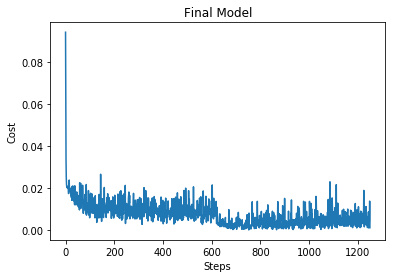

In [29]:
plt.clf()
fig = plt.figure()
plt.title('Final Model')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.plot(loss_performance[0])


In [190]:
def model_mistakes(dataset, model):
    """
    function to identify three correct and three incorrect
    """
    num = 0
    correct_list = []
    incorrect_list = []
    true_label_cor = []
    true_label_incor = []
    model.eval()
    for data, lengths, labels in dataset:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        if predicted[0].item() == label_batch[0].item():
            correct_list.append(num)
            true_label_cor.append(label_batch[0].item())
        else:
            incorrect_list.append(num)
            true_label_incor.append(label_batch[0].item())
        
        if len(correct_list) > 3 and len(incorrect_list) > 310:
            return correct_list, incorrect_list, true_label_cor, true_label_incor
        
        num += 1
    return print('fail')


In [176]:
val_dataset = NewsGroupDataset(val_data_indices, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=1,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [191]:
correct_list, incorrect_list, true_label_cor, true_label_incor = model_mistakes(val_loader, model)

In [198]:
all_correct = []
for y,x in enumerate(correct_list):
    all_correct.append((X_val.iloc[x], len(X_val.iloc[x]),true_label_cor[y]))

In [199]:
import operator
all_correct.sort(key = operator.itemgetter(1))

In [202]:
for x in range(0,3):
    print(all_correct[x][0])
    print(all_correct[x][2], '\n')

Obviously written for the stage. Lightweight but worthwhile. How can you go wrong with Ralph Richardson, Olivier and Merle Oberon.
1 

One of my favorite scenes is at the beginning when guests on a private yacht decide to take an impromptu swim - in their underwear! Rather risqué for 1931!
1 

Go, Igor, go, you are the proof that Slovenian films may, should and must be different. There's soul in it, and this is rare. Don't let anybody put you down!
1 



In [203]:
all_incorrect = []
for y,x in enumerate(incorrect_list):
    all_incorrect.append((X_val.iloc[x], len(X_val.iloc[x]),true_label_incor[y]))

all_incorrect.sort(key = operator.itemgetter(1))

for x in range(0,3):
    print(all_incorrect[x][0])
    print(all_incorrect[x][2], '\n')

wow...this has got to be the DUMBEST movie I've ever seen. We watched it in english class...and this movie made ABSOLUTELY no sense. I would never, EVER watch this movie again...and my sympathy to those who have ever PAID to see it.
0 

Summer Phoenix did a great performance where you really feel what she's not able to feel and you just cannot understand what she has on her mind. Besides, she portrays a jewish girl who behaves really confronting the status quo of that century.
1 

Laughs, adventure, a good time, a killer soundtrack, oscar-worthy acting, and special effects/ animitronics like none other, what else could you want in a movie? If you see this will be on the telly, WATCH IT, otherwise, run out now to RENT IT!!!
1 

